In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu1"
os.environ["CPATH"] = ""
import numpy as np

from collections import OrderedDict
from lasagnekit.misc.draw_net import draw_to_notebook, draw_to_file
from lasagnekit.misc.plot_weights import grid_plot
from lasagnekit.misc.dream import build_dreamer
from lasagnekit.easy import LightweightModel, BatchOptimizer
from lasagnekit.generative.capsule import Capsule
from lasagnekit.easy import BatchIterator, get_batch_slice


from lasagnekit.datasets.mnist import MNIST
from lasagnekit.datasets.fonts import Fonts

from lasagne import layers, updates
from IPython.display import SVG

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams


srng = RandomStreams(seed=234)


from skimage.io import imread
from skimage.transform import resize

from lasagnekit.easy import get_stat

import matplotlib.pyplot as plt

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, rectify

from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 1: Tesla K20m (CNMeM is disabled)


In [2]:
seed = 1234
np.random.seed(seed)
rng = RandomStreams(seed)

In [3]:
# choose between mnist and fonts
dataset = "mnist"

In [4]:
if dataset == "mnist":
    data = MNIST()
    data.load()
    X = data.X
    X = X.astype(np.float32)#theano expects float32 for GPUs
    y = data.y.astype(np.int32)
    real_w, real_h = 28, 28 # the real size of dataset
    output_dim = 10 # 10 classes
elif dataset == "fonts":
    data = Fonts(kind="all_64", 
                 labels_kind="letters")
    data.load()
    X = data.X
    X = X.astype(np.float32)
    y = data.y.astype(np.int32)
    output_dim = 26
    real_w, real_h = 64, 64
    X=1-X
X_orig = X
#y = label_binarize(y, np.arange(output_dim))
y = y.astype(np.float32)

In [5]:
print(X.shape, y.shape)

((70000, 784), (70000,))


In [6]:
w, h = 28, 28 # Desired resolution, not necessarely the same than real_w and real_h, 
              # if necessary the images will be resize to fit w and h)

In [7]:

binarize = False # binarize the images if "True"
rescale = True

if rescale is True:
    if (w, h) != (real_w, real_h):
        name = "{0}-{1}x{2}.npy".format(dataset, w, h)
        if os.path.exists(name):
            X =  np.load(name)
        else:
            from skimage.filter import threshold_otsu
            from skimage.transform import resize
            X_b = np.zeros((X.shape[0], w, h))
            for i in range(X_b.shape[0]):
                X_b[i] = resize(X_orig[i].reshape((real_w, real_h)), (w, h))
            X = X_b
            #X = X <= threshold_otsu(X)
            X = X.astype(np.float32)
            X = X.reshape((X.shape[0], w*h))
            #=1-X
            np.save(name, X)

if binarize is True:
    X = X <= threshold_otsu(X)
    X = 1 - X

(70000, 784)
(70000, 784)


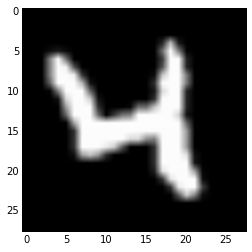

In [8]:
print(X.shape)
plt.imshow(X[20].reshape((w, h)), cmap="gray")
print(X.shape)

In [9]:
X, y = shuffle(X, y)
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

In [10]:
class MyBatchOptimizer(BatchOptimizer):
    # called for each epoch during training
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        return status
    
class Model:
    def get_all_params(self, **t):
        return list(set(self.image_to_style.get_all_params(**t) + 
                        self.styles_to_output.get_all_params(**t)))


# Model

In [11]:
model_type = "convnet"

In [12]:
if model_type == "fully_connected":
    ## fully connected
    num_hidden_units = 500
    input_dim = w * h
    output_dim = w * h

    # Style encoder network
    style_hidden_size = 10
    l_input_style_network = layers.InputLayer((None, w * h), name="input_style_network")
    l_encoder1 = layers.DenseLayer(l_input_style_network, num_units=num_hidden_units, nonlinearity=rectify)
    l_encoder2 = layers.DenseLayer(l_encoder1, num_units=num_hidden_units, nonlinearity=rectify)
    l_encoder3 = layers.DenseLayer(l_encoder2, num_units=num_hidden_units, nonlinearity=rectify)
    l_style = layers.DenseLayer(l_encoder3, num_units=style_hidden_size, nonlinearity=rectify)
    # Transformation Network
    
    
    l_source_transformation_network = layers.InputLayer((None,style_hidden_size), name="source_transformation_network")
    l_dest_transformation_network = layers.InputLayer((None,style_hidden_size), name="dest_transformation_network")
    l_merge = layers.ConcatLayer([l_source_transformation_network, l_dest_transformation_network], axis=1)
    l_encoder1 = layers.DenseLayer(l_merge, num_units=num_hidden_units, nonlinearity=rectify)
    l_encoder2 = layers.DenseLayer(l_encoder1, num_units=num_hidden_units, nonlinearity=rectify)
    l_encoder3 = layers.DenseLayer(l_encoder2, num_units=num_hidden_units, nonlinearity=rectify)    
    l_encoder4 = layers.DenseLayer(l_encoder3, num_units=num_hidden_units, nonlinearity=rectify)
    l_output = layers.DenseLayer(l_encoder4, num_units=output_dim, name="blending")
    
    # "sub"-models
    model = Model()
    model.image_to_style = LightweightModel([l_input_style_network], [l_style])
    model.styles_to_output = LightweightModel([l_source_transformation_network, l_dest_transformation_network], 
                                             [l_output])

In [120]:
if model_type == "convnet":
    ## fully connected
    num_hidden_units = 500
    input_dim = w * h
    output_dim = w * h
    
    # Style encoder network
    style_hidden_size = 10
    l_input_style_network = layers.InputLayer((None, w * h), name="input_style_network")
    l_in = layers.ReshapeLayer(l_input_style_network, ([0], 1, w, h))
    
    l_conv = layers.Conv2DLayer(l_in, num_filters=16, filter_size=(5, 5))
    l_pool = layers.Pool2DLayer(l_conv, pool_size=(2, 2))
    
    #l_conv = layers.Conv2DLayer(l_pool, num_filters=32, filter_size=(5, 5))
    #l_pool = layers.Pool2DLayer(l_conv, pool_size=(2, 2))
    
    l_hid = layers.DenseLayer(l_pool, num_units=500)
    l_style = layers.DenseLayer(l_hid, num_units=style_hidden_size, nonlinearity=lambda x:x)
    # Transformation Network
    
    
    l_source_transformation_network = layers.InputLayer((None,style_hidden_size), name="source_transformation_network")
    l_dest_transformation_network = layers.InputLayer((None,style_hidden_size), name="dest_transformation_network")
    
    l_merge = layers.ConcatLayer([l_source_transformation_network, l_dest_transformation_network], axis=1)
    l_encoder1 = layers.DenseLayer(l_merge, num_units=num_hidden_units, nonlinearity=rectify)
    l_encoder2 = layers.DenseLayer(l_encoder1, num_units=num_hidden_units, nonlinearity=rectify)
    
    k = 5
    #num = (((w - k + 1) / 2) - k + 1) / 2
    num = (w - k + 1) / 2
    
    l_encoder3 = layers.DenseLayer(l_encoder2, num_units=num*num*32, nonlinearity=rectify)
    
    l_pool_dec = layers.ReshapeLayer(l_encoder3, ([0], 32, num, num))
    l_pool_dec = layers.Upscale2DLayer(l_pool_dec, 2)
    
    l_conv_dec = layers.Conv2DLayer(l_pool_dec, num_filters=1, 
                                    filter_size=(5, 5), 
                                    pad='full')
    #l_pool_dec = layers.Upscale2DLayer(l_conv_dec, 2)
    #l_conv_dec = layers.Conv2DLayer(l_pool_dec, num_filters=1, filter_size=(5, 5),
    #                                pad='full')
    l_output = layers.ReshapeLayer(l_conv_dec, ([0], w*h))    
    # "sub"-models
    model = Model()
    model.image_to_style = LightweightModel([l_input_style_network], [l_style])
    model.styles_to_output = LightweightModel([l_source_transformation_network, l_dest_transformation_network], 
                                             [l_output])

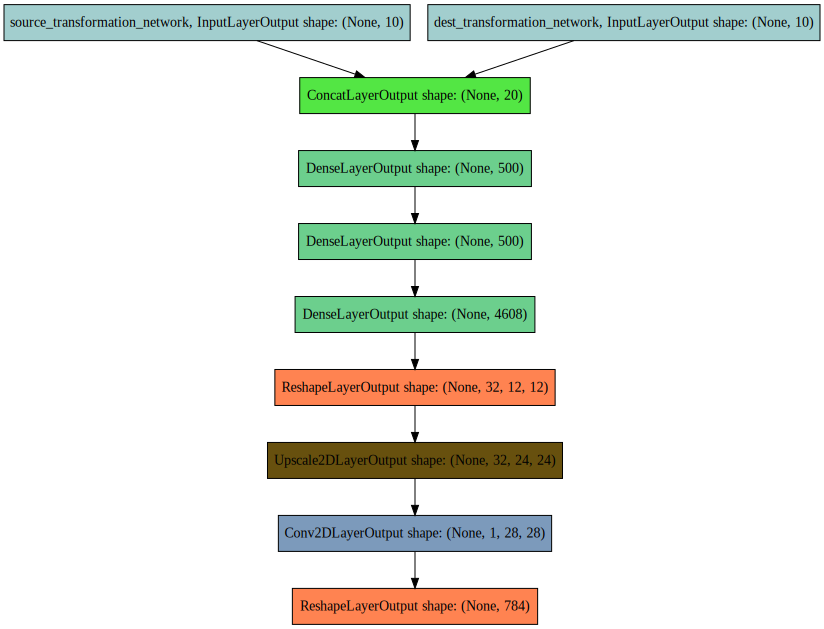

In [121]:
from IPython.display import SVG
draw_to_file(layers.get_all_layers(l_output), "unsupervised_style_transfer.svg")
SVG("unsupervised_style_transfer.svg")

In [122]:
layers_by_name = OrderedDict()


all_layers = (
    layers.get_all_layers(model.image_to_style.output_layers[0]) +
    layers.get_all_layers(model.styles_to_output.output_layers[0]) 
)

for l in all_layers:
    if l.name is not None:
        layers_by_name[l.name] = l
print(layers_by_name.keys())

['input_style_network', 'source_transformation_network', 'dest_transformation_network']


## Define the capsule object

The Capsule object combines all the components:

    - The model
    - The training algorithm
    - The loss function

In [123]:
input_variables = OrderedDict()
input_variables["input_image"] = dict(tensor_type=T.matrix)
input_variables["input_style_image"] = dict(tensor_type=T.matrix)

In [124]:
def get_output(model, input_image, input_style_image):
    source_style, = model.image_to_style.get_output(input_image)
    dest_style, = model.image_to_style.get_output(input_style_image)
    output, = model.styles_to_output.get_output(source_style, dest_style)
    return output

def get_style(model, input_image):
    output, = model.image_to_style.get_output(input_image)
    return output

functions = dict(
    get_ouput_blending=dict(
        get_output=get_output,
        params=["input_image", "input_style_image"]
    ),   
)

In [125]:
class BlendingBatchIterator(BatchIterator):
    
     def transform(self, batch_index, V):
        assert self.batch_size is not None 
        assert self.nb_batches is not None 
        tensors = OrderedDict()
        nb_examples = V["input_image"].shape[0]
        if isinstance(batch_index, T.TensorVariable):                        
            input_image_indices = rng.random_integers(size=(self.batch_size,), low=0, high=nb_examples)
            
            nb_examples = V["input_style_image"].shape[0]
            input_style_image_indices = rng.random_integers(size=(self.batch_size,), low=0, high=nb_examples)
        else:                        
            input_image_indices = np.random.randint(low=0, high=nb_examples, size=(self.batch_size,))
            input_style_image_indices = np.random.randint(low=0, high=nb_examples, size=(self.batch_size,))
        tensors["input_image"] = V["input_image"][input_image_indices]
        tensors["input_style_image"] = V["input_style_image"][input_style_image_indices]
        return tensors
batch_optimizer = MyBatchOptimizer(
    verbose=1,
    max_nb_epochs=20,
    batch_size=100,
    optimization_procedure=(updates.rmsprop, 
                            {"learning_rate": 0.0001})
)

In [134]:
def loss_function(model, tensors):
    input_image = tensors["input_image"]
    input_style_image = tensors["input_style_image"]
    
    style = get_style(model, input_style_image)
    
    
    output = get_output(model, input_image, input_style_image)
    
    style_output = get_style(model, output)
    
    
    
    recons = ((input_image - output) ** 2).sum(axis=1).mean()
    recons2 = ((style - style_output)**2).sum(axis=1).mean()
    return recons + recons2

In [132]:
capsule = Capsule(
    input_variables, 
    model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
    batch_iterator=BlendingBatchIterator(),
)

In [133]:
capsule.fit(input_image=X[y==0], input_style_image=X[y==0])

INFO (theano.gof.compilelock): Refreshing lock /grid_mnt/vol__vol_U__u/gridcl/mehdicherti/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.7-Carbon-x86_64-2.7.10-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /grid_mnt/vol__vol_U__u/gridcl/mehdicherti/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.7-Carbon-x86_64-2.7.10-64/lock_dir/lock


KeyboardInterrupt: 

In [129]:
input_images = X
input_images = input_images[np.random.randint(0, input_images.shape[0], size=100)]
input_style_images = X
input_style_images = input_style_images[np.random.randint(0, input_style_images.shape[0], size=100)]
output_images = capsule.get_ouput_blending(input_images, input_style_images)

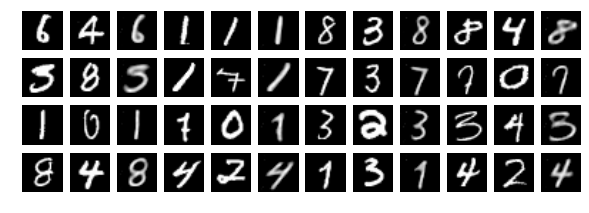

In [130]:
fig = plt.figure(figsize=(10, 10))
n = 4
gridw, gridh = n*3, n*3
k = 1
ind = 0
for i in range(n):
    for j in range(n):
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_images[ind].reshape((w, h)), cmap="gray")
        k += 1
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_style_images[ind].reshape((w, h)), cmap="gray")
        k += 1
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(output_images[ind].reshape((w, h)), cmap="gray")
        k += 1
        ind += 1
        plt.axis('off')
plt.show()